# ***Segmentation of Indian Traffic***

In [1]:
# Data Source:
!wget --header="Host: doc-0g-70-docs.googleusercontent.com" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-US,en;q=0.9" --header="Cookie: AUTH_quvsv3f7hvua6si0jcsst9neqmqcnn8o_nonce=1rla7mq0svfpe" --header="Connection: keep-alive" "https://doc-0g-70-docs.googleusercontent.com/docs/securesc/r5kf5b7cdb9m7vvltocpefcjv36j9hqe/2pq2vp9kmhno3h7ksjn2skjck5uqnjve/1626331650000/04779880292502345341/04779880292502345341/1HRBZe6Vo2EY7e8tc-sHD4GoQG220MaAX?e=download&authuser=0&nonce=1rla7mq0svfpe&user=04779880292502345341&hash=vl1sln3dnev3d87cnvs7al9rranfdg15" -c -O 'data.zip'

--2021-07-15 06:48:59--  https://doc-0g-70-docs.googleusercontent.com/docs/securesc/r5kf5b7cdb9m7vvltocpefcjv36j9hqe/2pq2vp9kmhno3h7ksjn2skjck5uqnjve/1626331650000/04779880292502345341/04779880292502345341/1HRBZe6Vo2EY7e8tc-sHD4GoQG220MaAX?e=download&authuser=0&nonce=1rla7mq0svfpe&user=04779880292502345341&hash=vl1sln3dnev3d87cnvs7al9rranfdg15
Resolving doc-0g-70-docs.googleusercontent.com (doc-0g-70-docs.googleusercontent.com)... 172.217.9.193, 2607:f8b0:4004:806::2001
Connecting to doc-0g-70-docs.googleusercontent.com (doc-0g-70-docs.googleusercontent.com)|172.217.9.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/x-zip-compressed]
Saving to: ‘data.zip’

data.zip                [          <=>       ]   2.18G  38.6MB/s    in 28s     

2021-07-15 06:49:27 (80.4 MB/s) - ‘data.zip’ saved [2339740971]



In [2]:
!unzip data.zip

Streaming output truncated to the last 5000 lines.
  inflating: data/images/377/frame28480_leftImg8bit.jpg  
  inflating: data/images/377/frame28699_leftImg8bit.jpg  
  inflating: data/images/377/frame28808_leftImg8bit.jpg  
  inflating: data/images/377/frame29080_leftImg8bit.jpg  
  inflating: data/images/377/frame29271_leftImg8bit.jpg  
  inflating: data/images/377/frame29435_leftImg8bit.jpg  
  inflating: data/images/377/frame29653_leftImg8bit.jpg  
  inflating: data/images/377/frame29817_leftImg8bit.jpg  
  inflating: data/images/377/frame30062_leftImg8bit.jpg  
  inflating: data/images/377/frame30199_leftImg8bit.jpg  
  inflating: data/images/377/frame3039_leftImg8bit.jpg  
  inflating: data/images/377/frame30417_leftImg8bit.jpg  
  inflating: data/images/377/frame30499_leftImg8bit.jpg  
  inflating: data/images/377/frame30608_leftImg8bit.jpg  
  inflating: data/images/377/frame30744_leftImg8bit.jpg  
  inflating: data/images/377/frame30908_leftImg8bit.jpg  
  inflating: data/imag

In [3]:
!pip install git+https://github.com/qubvel/segmentation_models

  Cloning https://github.com/qubvel/segmentation_models to /tmp/pip-req-build-9yhiygmk
  Running command git clone -q https://github.com/qubvel/segmentation_models /tmp/pip-req-build-9yhiygmk
  Running command git submodule update --init --recursive -q
     |████████████████████████████████| 51kB 7.4MB/s 
  Created wheel for segmentation-models: filename=segmentation_models-1.0.1-cp37-none-any.whl size=33810 sha256=b7ea9792077fbde6114bf8713f36d51dd0933d1ca1b8651fec4590767d07531f
  Stored in directory: /tmp/pip-ephem-wheel-cache-2y5c7vm3/wheels/49/cf/46/cbb4bb64518c402aea99df9d466f1081450597e653256bbcf4
Successfully built segmentation-models


In [4]:
import warnings
warnings.filterwarnings('ignore')

import math
from PIL import Image, ImageDraw
from PIL import ImagePath
import pandas as pd
import os
from os import path
from tqdm import tqdm
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import urllib
from sklearn.model_selection import train_test_split
import imgaug.augmenters as iaa
import gc
import tensorflow as tf
import math 
from PIL import Image, ImageDraw 
from PIL import ImagePath
import segmentation_models as sm
from segmentation_models.metrics import iou_score
from segmentation_models import Unet

Segmentation Models: using `keras` framework.


## ***Data Preparation***

In [5]:
def return_file_names_df():
    directory_images = 'data/images'
    directory_mask = 'data/mask'
    image_folders = sorted(os.listdir('data/images'))
    mask_folders = sorted(os.listdir('data/mask'))
    all_image_files = []
    folder_number_image = []
    for i in image_folders:
        image_files = sorted(os.listdir(directory_images + '/' + i))
        length_1 = [i]*len(image_files)
        all_image_files = all_image_files + image_files
        folder_number_image = folder_number_image + length_1
    all_json_files = []
    folder_number_json = []
    for j in mask_folders:
        json_files = sorted(os.listdir(directory_mask + '/' + j))
        length_2 = [j]*len(json_files)
        all_json_files = all_json_files + json_files
        folder_number_json = folder_number_json + length_2
    all_image_paths = []
    all_json_paths = []
    for k in range(len(folder_number_image)):
        image_path = directory_images + '/' + folder_number_image[k] + '/' + all_image_files[k]
        json_path = directory_mask + '/' + folder_number_json[k] + '/' + all_json_files[k]
        all_image_paths.append(image_path)
        all_json_paths.append(json_path)
    data_df = pd.DataFrame({'image' : all_image_paths, 'json' : all_json_paths})
    return data_df

In [6]:
data_df = return_file_names_df()
data_df.head()

,image,json
0,data/images/201/frame0029_leftImg8bit.jpg,data/mask/201/frame0029_gtFine_polygons.json
1,data/images/201/frame0299_leftImg8bit.jpg,data/mask/201/frame0299_gtFine_polygons.json
2,data/images/201/frame0779_leftImg8bit.jpg,data/mask/201/frame0779_gtFine_polygons.json
3,data/images/201/frame1019_leftImg8bit.jpg,data/mask/201/frame1019_gtFine_polygons.json
4,data/images/201/frame1469_leftImg8bit.jpg,data/mask/201/frame1469_gtFine_polygons.json


In [7]:
def grader_1(data_df):
    for i in data_df.values:
        if not (path.isfile(i[0]) and path.isfile(i[1]) and i[0][12:i[0].find('_')]==i[1][10:i[1].find('_')]):
            return False
    return True

In [8]:
grader_1(data_df)

True

In [9]:
data_df.shape

(4008, 2)

In [10]:
def return_unique_labels(data_df):
    labels = []
    for i in tqdm(data_df['json']):
        f0 = open(i, 'r')
        f1 = json.load(f0)
        for j in f1['objects']:
            label = j.get('label', -1)
            labels.append(label)
        f0.close()
    return set(labels)

In [11]:
unique_labels = return_unique_labels(data_df)

100%|██████████| 4008/4008 [00:30<00:00, 131.10it/s]


In [12]:
label_clr = {'road':10, 'parking':20, 'drivable fallback':20,'sidewalk':30,'non-drivable fallback':40,'rail track':40,\
                        'person':50, 'animal':50, 'rider':60, 'motorcycle':70, 'bicycle':70, 'autorickshaw':80,\
                        'car':80, 'truck':90, 'bus':90, 'vehicle fallback':90, 'trailer':90, 'caravan':90,\
                        'curb':100, 'wall':100, 'fence':110,'guard rail':110, 'billboard':120,'traffic sign':120,\
                        'traffic light':120, 'pole':130, 'polegroup':130, 'obs-str-bar-fallback':130,'building':140,\
                        'bridge':140,'tunnel':140, 'vegetation':150, 'sky':160, 'fallback background':160,'unlabeled':0,\
                        'out of roi':0, 'ego vehicle':170, 'ground':180,'rectification border':190,\
                   'train':200}

In [13]:
def grader_2(unique_labels):
    if (not (set(label_clr.keys())-set(unique_labels))) and len(unique_labels) == 40:
        print("True")
    else:
        print("Flase")

grader_2(unique_labels)

True


In [14]:
def get_poly(file):
    f0 = open(file, 'r')
    f1 = json.load(f0)
    f0.close()
    w = f1['imgWidth']
    h = f1['imgHeight']
    labels = []
    vertexlist_0 = []
    for i in f1['objects']:
        labels.append(i.get('label', -1))
        vertexlist_0.append(i.get('polygon', -1))
    vertexlist = []
    for i in vertexlist_0:
        k = []
        for j in i:
            k.append(tuple(j))
        vertexlist.append(k)
    return w, h, labels, vertexlist

In [15]:
def grader_3(file):
    w, h, labels, vertexlist = get_poly(file)
    print(len((set(labels)))==18 and len(vertexlist)==227 and w==1920 and h==1080 \
          and isinstance(vertexlist,list) and isinstance(vertexlist[0],list) and isinstance(vertexlist[0][0],tuple) )

grader_3('data/mask/201/frame0029_gtFine_polygons.json')

True


In [16]:
image_meta_data = {}
for i in tqdm(data_df['json']):
    w, h, labels, vertexlist = get_poly(i)
    image_meta_data[i] = [w, h, labels, vertexlist]

100%|██████████| 4008/4008 [00:55<00:00, 71.83it/s] 


In [17]:
output_folders = data_df['json'].apply(lambda x : '/'.join(x.split('/')[:3]).replace('mask', 'output'))
for i in output_folders:
    os.makedirs(i, exist_ok = True)

In [18]:
def compute_masks(data_df):
    mask_files = []
    for i in tqdm(data_df['json']):
        width, height, all_labels, indices = image_meta_data[i]
        mask_file = i.replace('mask', 'output').replace('json', 'png')
        mask_files.append(mask_file)
        img = Image.new('RGB', (width, height))
        img1 = ImageDraw.Draw(img)
        for j in range(len(all_labels)):
            try:
                img1.polygon(indices[j], fill = label_clr[all_labels[j]])
            except:
                continue
        img = np.array(img)
        im = Image.fromarray(img[:, :, 0])
        im.save(mask_file)
    data_df['mask'] = mask_files
    return data_df

In [19]:
data_df = compute_masks(data_df)
data_df.head()

100%|██████████| 4008/4008 [03:19<00:00, 20.11it/s]


,image,json,mask
0,data/images/201/frame0029_leftImg8bit.jpg,data/mask/201/frame0029_gtFine_polygons.json,data/output/201/frame0029_gtFine_polygons.png
1,data/images/201/frame0299_leftImg8bit.jpg,data/mask/201/frame0299_gtFine_polygons.json,data/output/201/frame0299_gtFine_polygons.png
2,data/images/201/frame0779_leftImg8bit.jpg,data/mask/201/frame0779_gtFine_polygons.json,data/output/201/frame0779_gtFine_polygons.png
3,data/images/201/frame1019_leftImg8bit.jpg,data/mask/201/frame1019_gtFine_polygons.json,data/output/201/frame1019_gtFine_polygons.png
4,data/images/201/frame1469_leftImg8bit.jpg,data/mask/201/frame1469_gtFine_polygons.json,data/output/201/frame1469_gtFine_polygons.png


False
[  0  10  20  40  50  60  70  80  90 100 120 130 140 150 160]
[  0  10  20  40  50  60  70  80  90 100 120 130 140 150 160]


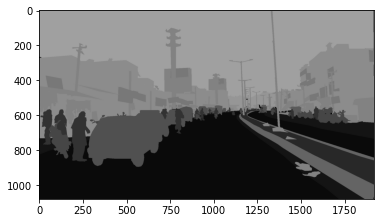

In [20]:
def grader_3():
    url = "https://i.imgur.com/4XSUlHk.png"
    url_response = urllib.request.urlopen(url)
    img_array = np.array(bytearray(url_response.read()), dtype=np.uint8)
    img = cv2.imdecode(img_array, -1)
    my_img = cv2.imread('data/output/201/frame0029_gtFine_polygons.png')    
    plt.imshow(my_img)
    print((my_img[:,:,0]==img).all())
    print(np.unique(img))
    print(np.unique(my_img[:,:,0]))
    data_df.to_csv('preprocessed_data.csv', index=False)
grader_3()

In [21]:
aug2 = iaa.Fliplr(1)
aug3 = iaa.Flipud(1)
aug4 = iaa.Emboss(alpha = (1), strength = 1)
aug5 = iaa.DirectedEdgeDetect(alpha = (0.8), direction = (1))
aug6 = iaa.Sharpen(alpha = (1.0), lightness = (1.5))

In [22]:
class Dataset:

    CLASSES = list(set(label_clr.values()))

    def __init__(self, image_file_names, mask_file_names, flag = True):
        self.ids = [i.split('/')[-1].split('_')[0] for i in image_file_names]
        self.images_fps = image_file_names
        self.masks_fps = mask_file_names
        self.class_values = CLASSES
        self.flag = flag

    def __getitem__(self, i):
        image = cv2.imread(self.images_fps[i], cv2.IMREAD_UNCHANGED)
        image = cv2.resize(image, (256, 256), interpolation = cv2.INTER_NEAREST)
        mask  = cv2.imread(self.masks_fps[i], cv2.IMREAD_UNCHANGED)
        mask = cv2.resize(mask, (256, 256), interpolation = cv2.INTER_NEAREST)
        image_masks = [(mask == v) for v in self.class_values]
        image_mask = np.stack(image_masks, axis = -1).astype('float')
        if self.flag:
            a = np.random.uniform()
            if a < 0.2:
                image = aug2.augment_image(image)
                image_mask = aug2.augment_image(image_mask)
            elif a < 0.4:
                image = aug3.augment_image(image)
                image_mask = aug3.augment_image(image_mask)
            elif a < 0.6:
                image = aug4.augment_image(image)
                image_mask = aug4.augment_image(image_mask)
            elif a < 0.8:
                image = aug5.augment_image(image)
                image_mask = image_mask
            else:
                image = aug6.augment_image(image)
                image_mask = aug6.augment_image(image_mask)
                    
        return image, image_mask

    def __len__(self):
        return len(self.ids)

In [23]:
class Dataloder(tf.keras.utils.Sequence):    
    def __init__(self, dataset, batch_size = 1, shuffle = False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

    def __getitem__(self, i):
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        batch = [np.stack(samples, axis = 0) for samples in zip(*data)]
        
        return tuple(batch)
    
    def __len__(self):
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)

In [24]:
X_train, X_test = train_test_split(data_df[['image', 'mask']], test_size = 0.15, random_state = 42)

In [25]:
def scheduler(epoch, lr):
    if epoch % 2 == 1:
        print('Reducing the learning rate by 10 %')
        return lr*0.9
    else:
        return lr

In [26]:
CLASSES = list(set(label_clr.values()))

train_dataset = Dataset(list(X_train['image']), list(X_train['mask']), flag = True)
test_dataset  = Dataset(list(X_test['image']), list(X_test['mask']), flag = False)

train_dataloader = Dataloder(train_dataset, batch_size = 2, shuffle = True)
test_dataloader = Dataloder(test_dataset, batch_size = 2, shuffle = True)

callbacks = [tf.keras.callbacks.ModelCheckpoint('./best_model.h5', save_weights_only = True, save_best_only = True, mode = 'min', monitor = 'val_iou_score'),
             tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_iou_score', min_lr = 0.000001, patience = 2), tf.keras.callbacks.LearningRateScheduler(scheduler)]

In [27]:
sm.set_framework('tf.keras')
tf.keras.backend.set_image_data_format('channels_last')

## ***UNet***

In [ ]:
model = Unet('resnet34', encoder_weights = 'imagenet', classes = 21, activation = 'softmax', input_shape = (256, 256, 3))
model.summary()

Model: "model_14"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 256, 256, 3)  9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_34 (ZeroPadding2 (None, 262, 262, 3)  0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 128, 128, 64) 9408        zero_padding2d_34[0][0]          
___________________________________________________________________________________________

In [ ]:
optim = tf.keras.optimizers.Adam(0.01, clipvalue = 0.5)
focal_loss = sm.losses.cce_dice_loss

In [ ]:
model.compile(optim, focal_loss, metrics = [sm.metrics.IOUScore(threshold = 0.5)])

In [ ]:
history = model.fit_generator(train_dataloader, steps_per_epoch = len(train_dataloader), epochs = 15,
                              validation_data = test_dataloader, callbacks = callbacks)

Epoch 1/15
1703/1703 [==============================] - 268s 154ms/step - loss: 0.9132 - iou_score: 0.3918 - val_loss: 1.5191 - val_iou_score: 0.2841
Epoch 2/15
Reducing the learning rate by 10 %
1703/1703 [==============================] - 261s 153ms/step - loss: 0.6945 - iou_score: 0.4024 - val_loss: 0.6692 - val_iou_score: 0.4205
Epoch 3/15
1703/1703 [==============================] - 260s 152ms/step - loss: 0.6507 - iou_score: 0.4206 - val_loss: 0.6852 - val_iou_score: 0.3926
Epoch 4/15
Reducing the learning rate by 10 %
1703/1703 [==============================] - 260s 152ms/step - loss: 0.6154 - iou_score: 0.4345 - val_loss: 0.6342 - val_iou_score: 0.4198
Epoch 5/15
1703/1703 [==============================] - 258s 152ms/step - loss: 0.6078 - iou_score: 0.4388 - val_loss: 0.6367 - val_iou_score: 0.4133
Epoch 6/15
Reducing the learning rate by 10 %
1703/1703 [==============================] - 258s 152ms/step - loss: 0.6021 - iou_score: 0.4392 - val_loss: 0.6277 - val_iou_score: 0.

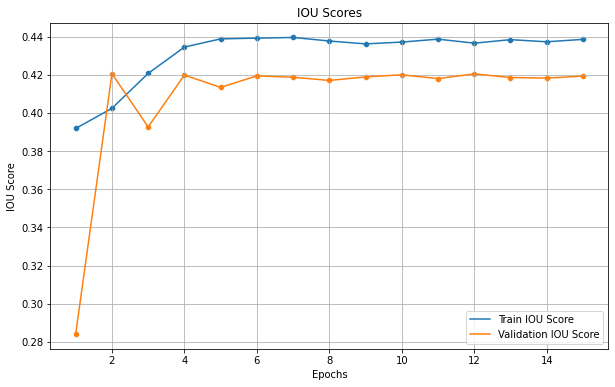

In [ ]:
plt.figure(figsize = (10, 6))
plt.grid()
plt.title('IOU Scores')
sns.lineplot(range(1, len(history.history['iou_score']) + 1), history.history['iou_score'])
sns.scatterplot(range(1, len(history.history['iou_score']) + 1), history.history['iou_score'])
sns.lineplot(range(1, len(history.history['val_iou_score']) + 1), history.history['val_iou_score'])
sns.scatterplot(range(1, len(history.history['val_iou_score']) + 1), history.history['val_iou_score'])
plt.legend(['Train IOU Score', 'Validation IOU Score'])
plt.xlabel('Epochs')
plt.ylabel('IOU Score')
plt.show()

In [ ]:
for i in range(0, len(X_test), 20):
    image = cv2.imread(data_df['image'][i], cv2.IMREAD_UNCHANGED)
    image = cv2.resize(image, (256, 256), interpolation = cv2.INTER_NEAREST)
    
    mask = cv2.imread(data_df['mask'][i], cv2.IMREAD_UNCHANGED)
    mask = cv2.resize(mask, (256, 256), interpolation = cv2.INTER_NEAREST)
    
    prediction = model.predict(image.reshape(1, 256, 256, 3))
    prediction = tf.argmax(prediction[0], axis = -1)
    
    plt.figure(figsize = (15, 6))
    
    plt.subplot(131)
    plt.title('Image')
    plt.imshow(image)

    plt.subplot(132)
    plt.title('Mask')
    plt.imshow(mask)

    plt.subplot(133)
    plt.title('Prediction')
    plt.imshow(prediction)

    plt.show()

Output hidden; open in https://colab.research.google.com to view.

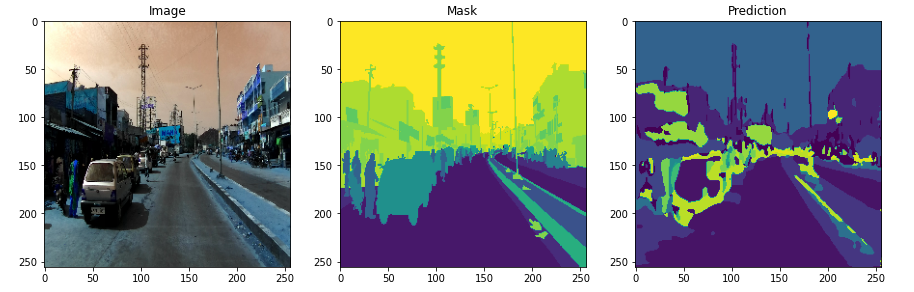

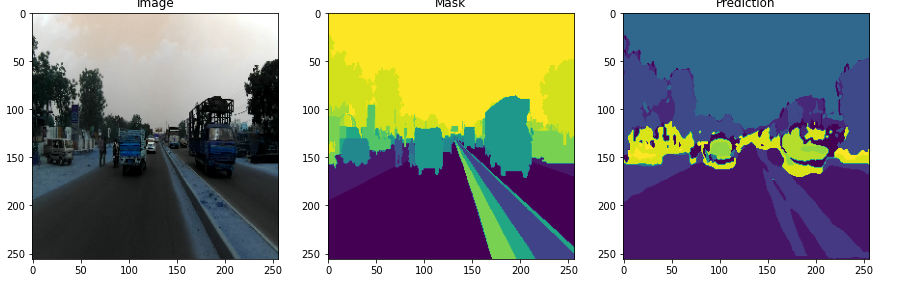

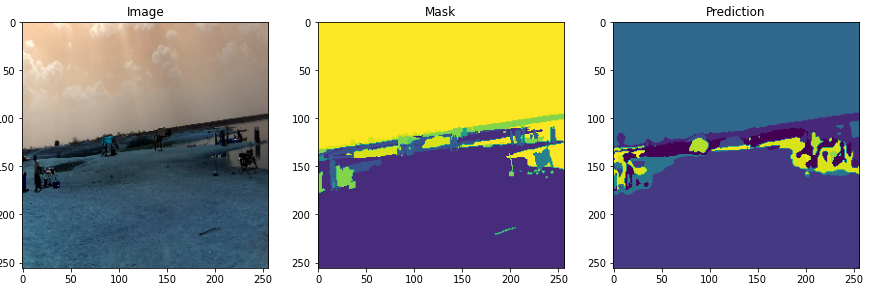

## ***CANet***



In [28]:
train_dataloader = Dataloder(train_dataset, batch_size = 2, shuffle = True)
test_dataloader = Dataloder(test_dataset, batch_size = 2, shuffle = True)

In [29]:
import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras import activations
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Conv2D, Flatten, BatchNormalization, Activation, UpSampling2D, Input, GlobalMaxPool2D, Concatenate, AveragePooling2D, GlobalAveragePooling2D, MaxPooling2D
from tensorflow.keras import Model

In [47]:
class convolutional_block(tf.keras.layers.Layer):

    def __init__(self,  filters = [4, 4, 8], stride = 1):
        super().__init__()
        self.F1, self.F2, self.F3 = filters
        self.stride = stride
        
        # Part 1
        self.conv_1 = Conv2D(filters = self.F1, kernel_size = 1, strides = 1, activation = 'relu', padding = 'same') # , kernel_initializer = 'he_normal'
        self.batch_1 = BatchNormalization(axis = 3)
        self.activation_1 = layers.Activation(activations.relu)
        self.conv_2 = Conv2D(filters = self.F2, kernel_size = 3, strides = self.stride, activation = 'relu', padding = 'same')
        self.batch_2 = BatchNormalization(axis = 3)
        self.activation_2 = layers.Activation(activations.relu)
        self.conv_3 = Conv2D(filters = self.F3, kernel_size = 1, strides = 1, activation = 'relu', padding = 'same')
        
        # Part 2
        self.conv_4 = Conv2D(filters = self.F3, kernel_size = 3, strides = self.stride, activation = 'relu', padding = 'same')
        self.batch_4 = BatchNormalization(axis = 3)
        self.activation_4 = layers.Activation(activations.relu)
        
        # Summation
        self.activation_5 = layers.Activation(activations.relu)

    def call(self, X):
      
        # Part 1
        conv_1 = self.conv_1(X)
        batch_1 = self.batch_1(conv_1)
        activation_1 = self.activation_1(batch_1)
        conv_2 = self.conv_2(activation_1)
        batch_2 = self.batch_2(conv_2)
        activation_2 = self.activation_2(batch_2)
        conv_3 = self.conv_3(activation_2)
        
        # Part 2
        conv_4 = self.conv_4(X)
        batch_4 = self.batch_4(conv_4)
        activation_4 = self.activation_4(batch_4)

        # Summation
        net_output = tf.add(conv_3, activation_4)
        activation_5 = self.activation_5(net_output)

        return activation_5

In [48]:
class identity_block(tf.keras.layers.Layer):
    def __init__(self, filters = [4, 4, 8]):
        super().__init__()
        self.F1, self.F2, self.F3 = filters
        self.conv_1 = Conv2D(self.F1, kernel_size = 1, strides = 1, padding = 'same', activation = 'relu')
        self.batch_1 = BatchNormalization(axis = 3)
        self.activation_1 = layers.Activation(activations.relu)
        self.conv_2 = Conv2D(self.F2, kernel_size = 3, strides = 1, padding = 'same', activation = 'relu')
        self.batch_2 = BatchNormalization(axis = 3)
        self.activation_2 = layers.Activation(activations.relu)
        self.conv_3 = Conv2D(self.F3, kernel_size = 1, strides = 1, padding = 'same', activation = 'relu')
        self.batch_3 = BatchNormalization(axis = 3)
    def call(self, X):
        conv_1 = self.conv_1(X)
        batch_1 = self.batch_1(conv_1)
        activation_1 = self.activation_1(batch_1)
        conv_2 = self.conv_2(activation_1)
        batch_2 = self.batch_2(conv_2)
        activation_2 = self.activation_2(batch_2)
        conv_3 = self.conv_3(activation_2)
        output = tf.add(X, conv_3)
        return output

In [49]:
class global_flow(tf.keras.layers.Layer):
    def __init__(self):
        super().__init__()
        self.pooling = GlobalAveragePooling2D()
        self.batch = BatchNormalization()
        self.activation = layers.Activation(activations.relu)
        # EDITED: self.conv = Conv2D(64, kernel_size = 1, strides = 1, activation = 'relu')
        self.conv = Conv2D(32, kernel_size = 1, strides = 1, activation = 'relu')
        self.upsample = UpSampling2D(size = (32, 32), interpolation = 'bilinear')
        
    def call(self, X):
        pool = self.pooling(X)
        batch = self.batch(pool)
        activation = self.activation(batch)[:, np.newaxis, np.newaxis, :]
        conv = self.conv(activation)
        upsample = self.upsample(conv)
        return upsample

In [50]:
class context_flow(tf.keras.layers.Layer):    
    def __init__(self):
        super().__init__()
        
        # Part 1
        # EDITED: self.concatenate = Concatenate(axis = -1)
        self.concatenate = Concatenate()
        self.pooling = AveragePooling2D()
        # EDITED: self.conv_1 = Conv2D(64, kernel_size = 3, strides = 1, activation = 'relu', padding = 'same')
        self.conv_1 = Conv2D(32, kernel_size = 3, strides = 1, activation = 'relu', padding = 'same')
        # EDITED: self.conv_2 = Conv2D(64, kernel_size = 3, strides = 1, activation = 'relu', padding = 'same')
        self.conv_2 = Conv2D(32, kernel_size = 3, strides = 1, activation = 'relu', padding = 'same')

        # Part 2
        # EDITED: self.conv_3 = Conv2D(64, kernel_size = 1, strides = 1, activation = 'relu', padding = 'same')
        self.conv_3 = Conv2D(32, kernel_size = 1, strides = 1, activation = 'relu', padding = 'same')
        self.activation_1 = layers.Activation(activations.relu)
        # EDITED: self.conv_4 = Conv2D(64, kernel_size = 1, strides = 1, activation = 'relu', padding = 'same')
        self.conv_4 = Conv2D(32, kernel_size = 1, strides = 1, activation = 'relu', padding = 'same')
        self.activation_2 = layers.Activation(activations.sigmoid)
        # EDITED: self.upsample = UpSampling2D(interpolation = 'bilinear')
        self.upsample = UpSampling2D((2, 2), interpolation = 'bilinear')

    def call(self, X):
        INP, FLOW = X[0], X[1]
        
        # Part 1
        concatenate = self.concatenate([INP, FLOW])
        pooling = self.pooling(concatenate)
        conv_1 = self.conv_1(pooling)
        conv_2 = self.conv_2(conv_1)

        # Part 2
        conv_3 = self.conv_3(conv_2)
        activation_1 = self.activation_1(conv_3)
        conv_4 = self.conv_4(activation_1)
        activation_2 = self.activation_2(conv_4)
        mul = tf.multiply(activation_2, conv_2)
        add = tf.add(mul, conv_2)
        upsample = self.upsample(add)        
        return upsample

In [51]:
class fsm(tf.keras.layers.Layer):    
    def __init__(self):
        super().__init__()
        self.conv_1 = Conv2D(filters = 32, kernel_size = 3, strides = 1, activation = 'relu', padding = 'same')
        self.pooling = GlobalMaxPool2D()
        self.conv_2 = Conv2D(filters = 32, kernel_size = 1, strides = 1, activation = 'relu', padding = 'same')
        self.batch = BatchNormalization()
        self.activation = layers.Activation(activations.sigmoid)
        self.upsample = UpSampling2D(size = (2, 2), interpolation = 'bilinear')
    def call(self, X):
        conv_1 = self.conv_1(X)
        pooling = tf.reshape(self.pooling(conv_1), shape = (-1, 1, 1, 32))
        conv_2 = self.conv_2(pooling)
        batch = self.batch(conv_2)
        activation = self.activation(batch)
        mul = tf.multiply(activation, conv_1)
        upsample = self.upsample(mul)
        return upsample

In [52]:
class agcn(tf.keras.layers.Layer):    
    def __init__(self):
        super().__init__()
        
        self.conv_11 = Conv2D(filters = 32, kernel_size = (7, 1), strides = 1, activation = 'relu', padding = 'same')
        self.conv_12 = Conv2D(filters = 32, kernel_size = (1, 7), strides = 1, activation = 'relu', padding = 'same')
        
        self.conv_21 = Conv2D(filters = 32, kernel_size = (1, 7), strides = 1, activation = 'relu', padding = 'same')
        self.conv_22 = Conv2D(filters = 32, kernel_size = (7, 1), strides = 1, activation = 'relu', padding = 'same')

        self.conv_3 = Conv2D(filters = 32, kernel_size = 3, strides = 1, activation = 'relu', padding = 'same')
        
    def call(self, X):
        conv_11 = self.conv_11(X)
        conv_12 = self.conv_12(conv_11)
        conv_21 = self.conv_21(X)
        conv_22 = self.conv_22(conv_21)
        add_1 = tf.add(conv_12, conv_22)
        conv_3 = self.conv_3(add_1)
        return tf.add(add_1, conv_3)

In [53]:
input = Input(shape = (256, 256, 3))

conv_1 = Conv2D(filters = 64, kernel_size = 3, strides = 1, activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(input)

batch = BatchNormalization(axis = 3)(conv_1)

activation = layers.Activation(activations.relu)(batch)

pool = MaxPooling2D(pool_size = (2, 2), strides = (2, 2))(activation)

convolution_1 = convolutional_block(filters = [4, 4, 8], stride = 2)(pool)
identity_1 = identity_block(filters = [4, 4, 8])(convolution_1)

convolution_2 = convolutional_block(filters = [4, 4, 16], stride = 2)(identity_1)
identity_21 = identity_block(filters = [4, 4, 16])(convolution_2)
identity_22 = identity_block(filters = [4, 4, 16])(identity_21)

convolution_3 = convolutional_block(filters = [4, 4, 32], stride = 1)(identity_22)
identity_31 = identity_block(filters = [4, 4, 32])(convolution_3)
identity_32 = identity_block(filters = [4, 4, 32])(identity_31)
identity_33 = identity_block(filters = [4, 4, 32])(identity_32)

convolution_4 = convolutional_block(filters = [4, 4, 64], stride = 1)(identity_33)
identity_41 = identity_block(filters = [4, 4, 64])(convolution_4)
identity_42 = identity_block(filters = [4, 4, 64])(identity_41)
identity_43 = identity_block(filters = [4, 4, 64])(identity_42)
identity_44 = identity_block(filters = [4, 4, 64])(identity_43)

global_flow = global_flow()(identity_44)

context_flow_1 = context_flow()([global_flow, identity_44])
context_flow_2 = context_flow()([context_flow_1, identity_44])
context_flow_3 = context_flow()([context_flow_2, identity_44])

add_1 = tf.add(global_flow, context_flow_1, context_flow_2)
add_2 = tf.add(add_1, context_flow_3)

fsm = fsm()(add_2)

agcn = agcn()(convolution_1)

concat = Concatenate(axis = -1)([agcn, fsm])

conv_2 = Conv2D(filters = 21, kernel_size = 3, strides = 1, activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(concat)

upsample = UpSampling2D(size = (4, 4), interpolation = 'bilinear')(conv_2)

activation = layers.Activation(activations.softmax)(upsample)

model = Model(inputs = input, outputs = activation)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_115 (Conv2D)             (None, 256, 256, 64) 1792        input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_88 (BatchNo (None, 256, 256, 64) 256         conv2d_115[0][0]                 
__________________________________________________________________________________________________
activation_83 (Activation)      (None, 256, 256, 64) 0           batch_normalization_88[0][0]     
____________________________________________________________________________________________

In [54]:
optim = tf.keras.optimizers.Adam(0.01, clipvalue = 0.5)
focal_loss = sm.losses.cce_dice_loss

In [55]:
model.compile(optim, focal_loss, metrics = [sm.metrics.IOUScore(threshold = 0.5)])

In [56]:
callbacks = [tf.keras.callbacks.ModelCheckpoint('./best_model_canet.h5', save_weights_only = True, save_best_only = True, mode = 'min', monitor = 'val_iou_score'),
             tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_iou_score', min_lr = 0.000001, patience = 2), tf.keras.callbacks.LearningRateScheduler(scheduler)]

In [57]:
history = model.fit_generator(train_dataloader, steps_per_epoch = len(train_dataloader), epochs = 5,
                              validation_data = test_dataloader, callbacks = callbacks)

Epoch 1/5
1703/1703 [==============================] - 261s 150ms/step - loss: 0.9356 - iou_score: 0.3902 - val_loss: 0.9579 - val_iou_score: 0.3790
Epoch 2/5
Reducing the learning rate by 10 %
1703/1703 [==============================] - 259s 152ms/step - loss: 0.8868 - iou_score: 0.4196 - val_loss: 0.9142 - val_iou_score: 0.3975
Epoch 3/5
1703/1703 [==============================] - 257s 151ms/step - loss: 0.8695 - iou_score: 0.4317 - val_loss: 0.8937 - val_iou_score: 0.4176
Epoch 4/5
Reducing the learning rate by 10 %
1703/1703 [==============================] - 258s 152ms/step - loss: 0.8446 - iou_score: 0.4487 - val_loss: 0.8538 - val_iou_score: 0.4386
Epoch 5/5
1703/1703 [==============================] - 257s 151ms/step - loss: 0.8388 - iou_score: 0.4535 - val_loss: 0.8533 - val_iou_score: 0.4395


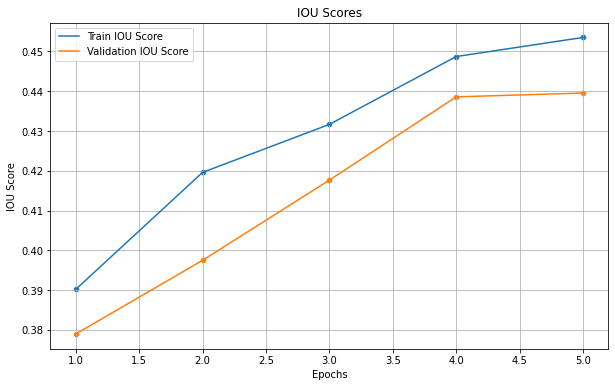

In [58]:
plt.figure(figsize = (10, 6))
plt.grid()
plt.title('IOU Scores')
sns.lineplot(range(1, len(history.history['iou_score']) + 1), history.history['iou_score'])
sns.scatterplot(range(1, len(history.history['iou_score']) + 1), history.history['iou_score'])
sns.lineplot(range(1, len(history.history['val_iou_score']) + 1), history.history['val_iou_score'])
sns.scatterplot(range(1, len(history.history['val_iou_score']) + 1), history.history['val_iou_score'])
plt.legend(['Train IOU Score', 'Validation IOU Score'])
plt.xlabel('Epochs')
plt.ylabel('IOU Score')
plt.show()

In [59]:
for i in range(0, len(X_test), 20):
    image = cv2.imread(data_df['image'][i], cv2.IMREAD_UNCHANGED)
    image = cv2.resize(image, (256, 256), interpolation = cv2.INTER_NEAREST)
    
    mask = cv2.imread(data_df['mask'][i], cv2.IMREAD_UNCHANGED)
    mask = cv2.resize(mask, (256, 256), interpolation = cv2.INTER_NEAREST)
    
    prediction = model.predict(image.reshape(1, 256, 256, 3))
    prediction = tf.argmax(prediction[0], axis = -1)
    
    plt.figure(figsize = (15, 6))
    
    plt.subplot(131)
    plt.title('Image')
    plt.imshow(image)

    plt.subplot(132)
    plt.title('Mask')
    plt.imshow(mask)

    plt.subplot(133)
    plt.title('Prediction')
    plt.imshow(prediction)

    plt.show()

Output hidden; open in https://colab.research.google.com to view.

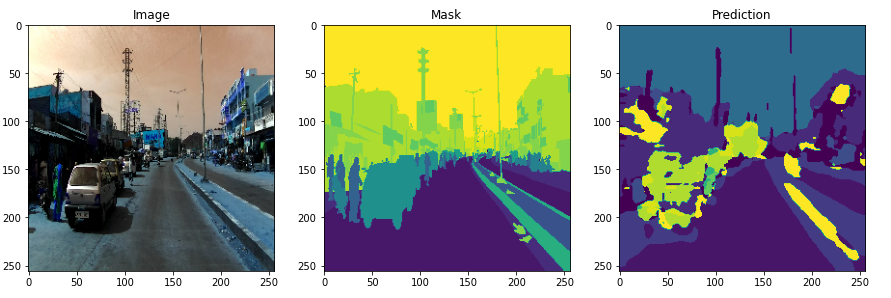

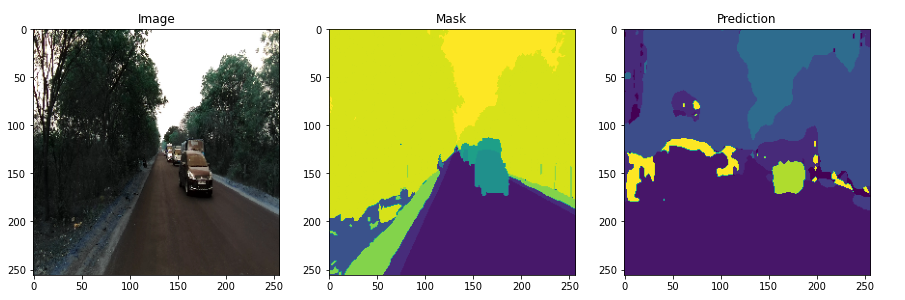

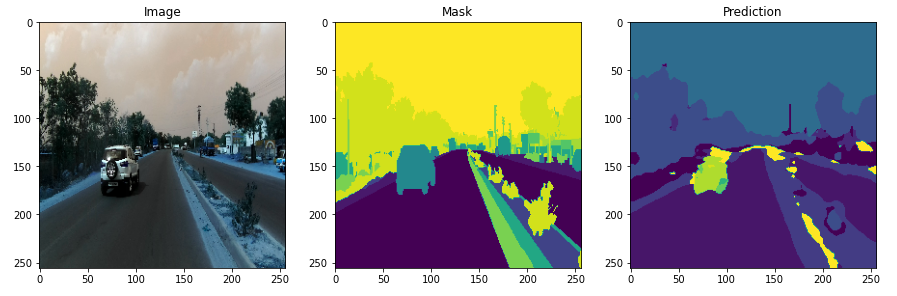